## Download Dataset

In [ ]:
!nvidia-smi

Sun Oct 30 09:42:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q kaggle

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/KaggleAPI/kaggle.json ~/.kaggle/ #copy api key ---- depend on your directory -- my directory is .../colab/..
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list
!kaggle competitions download -c hackathon-online-2022-image-processing #download competition dataset
!unzip /content/hackathon-online-2022-image-processing.zip
!mkdir /content/zipfile
!unzip /content/IM_Test.zipfile -d /content/zipfile
!unzip /content/IM_Train.zipfile -d /content/zipfile
!mkdir /content/dataset/
!unzip /content/zipfile/IM_Train.zipfile -d /content/dataset
!unzip /content/zipfile/IM_Test.zipfile -d /content/dataset/test
!rm -r /content/zipfile

In [ ]:
# !kaggle competitions submit -c hackathon-online-2022-image-processing -f /content/IM_Submit.csv -m "test send submit file from colab"

## **Import and Preprocess Dataset**
Do an image augmentation which consist of rotation, width/height shift, shear and zoom. Then split the dataset 20% as validation dataset and 80% as train dataset.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/dataset/train'
w ,h = 150,150
# image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest',
      validation_split=0.2)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(w, h),  # All images will be resized to 32x32
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(w, h),
        batch_size=64,
        class_mode='categorical',
        subset='validation')

Found 58609 images belonging to 10 classes.
Found 14648 images belonging to 10 classes.


1

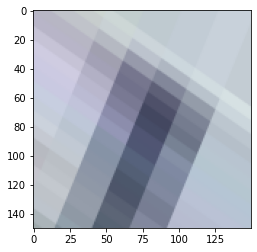

In [ ]:
randint = np.random.randint(0,len(train_generator[0][0]))
plt.imshow(np.array(train_generator[0][0][randint]))
train_generator[0][1][randint].argmax()

In [ ]:
train_generator[0][1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

## **Prepare a Model**
In this version I used transfer learning technique from RestNet50 and fine tuning by add Flatten, Dropout, Dense layers.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check accuracy
    if(logs.get('val_acc') > 0.88):

      # Stop if threshold is met
      print("\nDOING CALLBACK")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet',classes=10))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2)

Epoch 1/100
100/100 - 73s - loss: 1.6796 - accuracy: 0.4291 - val_loss: 6.1575 - val_accuracy: 0.1925 - 73s/epoch - 733ms/step
Epoch 2/100
100/100 - 52s - loss: 0.9217 - accuracy: 0.6925 - val_loss: 4.7853 - val_accuracy: 0.1828 - 52s/epoch - 523ms/step
Epoch 3/100
100/100 - 53s - loss: 0.7218 - accuracy: 0.7706 - val_loss: 6.2693 - val_accuracy: 0.1953 - 53s/epoch - 533ms/step
Epoch 4/100
100/100 - 53s - loss: 0.5972 - accuracy: 0.8191 - val_loss: 3.0659 - val_accuracy: 0.1934 - 53s/epoch - 531ms/step
Epoch 5/100
100/100 - 53s - loss: 0.5498 - accuracy: 0.8283 - val_loss: 3.2866 - val_accuracy: 0.1947 - 53s/epoch - 530ms/step
Epoch 6/100
100/100 - 53s - loss: 0.4994 - accuracy: 0.8481 - val_loss: 2.3983 - val_accuracy: 0.2400 - 53s/epoch - 534ms/step
Epoch 7/100
100/100 - 53s - loss: 0.4776 - accuracy: 0.8517 - val_loss: 1.8182 - val_accuracy: 0.3884 - 53s/epoch - 530ms/step
Epoch 8/100
100/100 - 53s - loss: 0.4438 - accuracy: 0.8708 - val_loss: 1.0739 - val_accuracy: 0.6397 - 53s/epo

In [11]:
model.save('/content/drive/MyDrive/saved_model/03model')
model.save('/content/drive/MyDrive/saved_model/03model/03model.h5')

In [12]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

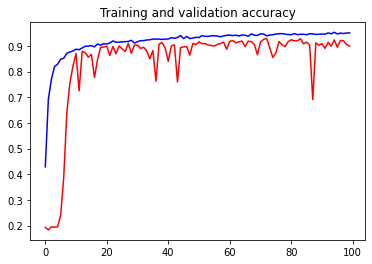

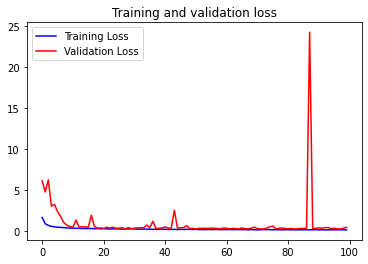

In [14]:
plot_loss_acc(history)
# plot_loss_acc(new_model)

## **TEST**

In [15]:
import os
import numpy as np
import tensorflow as tf

In [16]:
# new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/03model/03model.h5')
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/03model')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
from PIL import Image
import json

def jsonCustomFormatter(data) -> tuple[list,list]:
  filename= []
  for name in range(len(data)):
      for bbox in range(len(data[name]['bboxes'])):
          _name = data[name]['filename'].split('.')[0]+ "_" + str(data[name]['bboxes'][bbox]['bbox_id'])
          filename.append(_name)

  bboxes= []
  # (left, top, right, bottom)
  for name in range(len(data)):
      for bbox in range(len(data[name]['bboxes'])):
          _coor = []
          _coor.append(data[name]['bboxes'][bbox]['x1'])
          _coor.append(data[name]['bboxes'][bbox]['y1'])
          _coor.append(data[name]['bboxes'][bbox]['x2'])
          _coor.append(data[name]['bboxes'][bbox]['y2'])
          bboxes.append(_coor)

  return filename,bboxes


def normImg(imgArray):
  imgArray = imgArray / 255.
  return imgArray


def loadTestImage(path,test_filename,bboxes,w=300,h=300,):
  test_img = []
  for ele in range(len(test_filename)):
    img = Image.open(os.path.join(path,str(test_filename[ele].split('_')[0]))+".png")
    img = img.crop(bboxes[ele])
    img = img.resize((w,h))
    img = np.array(img)
    img = normImg(img)
    test_img.append(img)

  return np.array(test_img)


def JSONReader(json_path):
  f = open(json_path)
  with open(json_path, 'r', encoding='utf-8') as f:
      data = json.load(f)
  f.close()

  filename,bboxes = jsonCustomFormatter(data=data)
  del(data)

  return filename,bboxes


def BatchTest(path,filename,bboxes,model,w,h,batch_size):
  pred_res = []
  start = 0
  final = batch_size

  while True:
    try:
      test_img = loadTestImage(path,filename[start:final],bboxes[start:final],w,h))
      pred = model.predict(test_img)
      _pred_res = [ele.argmax() for ele in pred]
      for ele in _pred_res:
        pred_res.append(ele)
      start = final
      final = final + batch_size
    except LookupError:  
      print ("Index Error Exception Raised, list index out of range")

  return pred_res


In [18]:
json_path = '/content/dataset/test/IM_Test/IM_Test.json'

filename,bboxes = JSONReader(json_path)

len(filename),len(bboxes)

(26032, 26032)

In [ ]:
test_path = '/content/dataset/test/IM_Test/IM_Test'
w ,h = 150,150

pred_res = BatchTest(test_path,filename,bboxes,model,w,h,len(filename)/2)

In [19]:
# test_path = '/content/dataset/test/IM_Test/IM_Test'
# w ,h = 150,150
# pred_res = []
# test_img = np.array(loadTestImage(test_path,filename[0:int(len(filename)/2)],bboxes[0:int(len(filename)/2)] ,w=w,h=h))
# pred = model.predict(test_img)
# _pred_res = [x.argmax() for x in pred]
# for x in _pred_res:
#   pred_res.append(x)


# del(test_img)
# del(pred)

407/407 [==============================] - 23s 52ms/step


In [20]:
# test_img = np.array(loadTestData(test_path,filename[int(len(filename)/2):],bboxes[int(len(filename)/2):] ,w=w,h=h))
# pred = model.predict(test_img)
# _pred_res = [x.argmax() for x in pred]
# for x in _pred_res:
#   pred_res.append(x)

407/407 [==============================] - 21s 53ms/step


In [21]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Submit/IM_Submit.csv')
df['class'] = pred_res

df['imageid_boxid']

0            1_0
1            2_0
2            2_1
3            2_2
4            3_0
          ...   
26027    13067_0
26028    13067_1
26029    13067_2
26030    13068_0
26031    13068_1
Name: imageid_boxid, Length: 26032, dtype: object

In [22]:
df.to_csv('/content/drive/MyDrive/Submit/IM_Submit06.csv',index=False)

In [23]:
!kaggle competitions submit -c hackathon-online-2022-image-processing -f /content/drive/MyDrive/Submit/IM_Submit06.csv -m "Machine(s) learning I learned nothing"

100% 233k/233k [00:03<00:00, 67.6kB/s]
Successfully submitted to Hackathon Online: Image Processing